In [4]:
import pandas as pd 
import numpy as np 
from scipy.stats import chi2, shapiro

# Re-load the LDT Session 1 and LDT Session 2 data from the newly uploaded files
new_ldt_session_1_path = 'ldt_session_1_data_transformed.csv'
new_ldt_session_2_path = 'ldt_session_2_data_transformed.csv'

# Load the new data
new_ldt_session_1_data = pd.read_csv(new_ldt_session_1_path)
new_ldt_session_2_data = pd.read_csv(new_ldt_session_2_path)

# Check the first few rows to confirm data is loaded correctly
(new_ldt_session_1_data.head(), new_ldt_session_2_data.head())


(   Unnamed: 0                  Experiment   v1_mean   v2_mean   zr_mean  \
 0         368  001_class_words_part_1.dat  1.914128 -1.973710  0.458063   
 1         108  002_class_words_part_1.dat  1.444512 -2.546759  0.538214   
 2         347  003_class_words_part_1.dat  2.274300 -3.492228  0.558717   
 3          97  004_class_words_part_1.dat  2.067894 -3.060628  0.567937   
 4          62  005_class_words_part_1.dat  3.035132 -3.629939  0.470022   
 
      a_mean  ndt_mean  sndt_mean  alpha_mean  accuracy_percentage  ...  \
 0  1.068551  0.461645   0.072309    1.887123             0.899749  ...   
 1  1.205062  0.538549   0.032389    1.968847             0.914573  ...   
 2  1.293333  0.451020   0.014519    1.951431             0.977500  ...   
 3  0.912611  0.458700   0.049127    1.738777             0.930000  ...   
 4  1.330673  0.434927   0.020764    1.921688             0.985000  ...   
 
                                           RT_Cor_arr  ID  Task    Session  \
 0  1      0

In [5]:
new_ldt_session_1_data.insert(3, "v_total = v2_mean - v1_mean", new_ldt_session_1_data['v1_mean']-new_ldt_session_1_data['v2_mean'], True)
new_ldt_session_1_data.insert(4, "v_bias = v1_mean + v2_mean", new_ldt_session_1_data['v1_mean']+new_ldt_session_1_data['v2_mean'], True)


In [6]:
list(new_ldt_session_1_data)

['Unnamed: 0',
 'Experiment',
 'v1_mean',
 'v_total = v2_mean - v1_mean',
 'v_bias = v1_mean + v2_mean',
 'v2_mean',
 'zr_mean',
 'a_mean',
 'ndt_mean',
 'sndt_mean',
 'alpha_mean',
 'accuracy_percentage',
 'mean_log_rt',
 'RT_mean_correct_error',
 'mean_correct',
 'mean_error',
 'error_array',
 'RT_Cor_arr',
 'ID',
 'Task',
 'Session',
 'alpha_shifted',
 'alpha_clipped',
 'alpha_arcsin',
 'alpha_mean_boxcox_after_arcsin',
 'accuracy_arcsin',
 'accuracy_percentage_boxcox_after_arcsin']

In [7]:
new_ldt_session_2_data.insert(3, "v_total = v2_mean - v1_mean", new_ldt_session_2_data['v1_mean']-new_ldt_session_2_data['v2_mean'], True)
new_ldt_session_2_data.insert(4, "v_bias = v1_mean + v2_mean", new_ldt_session_2_data['v1_mean']+new_ldt_session_2_data['v2_mean'], True)


In [8]:
def safe_mahalanobis(x=None, data=None, cov=None):
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()



In [9]:
# Re-identifying outliers for v1_mean using the updated data
# Extract the data for v1_mean
new_ldt_1_v1_mean = new_ldt_session_1_data.set_index('ID')['v1_mean']
new_ldt_2_v1_mean = new_ldt_session_2_data.set_index('ID')['v1_mean']

# Ensure only matching IDs are kept for comparison
new_common_ids = new_ldt_1_v1_mean.index.intersection(new_ldt_2_v1_mean.index)
new_paired_v1_means = pd.concat([new_ldt_1_v1_mean.loc[new_common_ids], new_ldt_2_v1_mean.loc[new_common_ids]], axis=1, keys=['Session1', 'Session2'])

# Calculate Mahalanobis distance using the safe function
new_mahalanobis_dist = safe_mahalanobis(x=new_paired_v1_means, data=new_paired_v1_means)

# Determine the threshold for p < 0.001
p_value = 0.001
new_threshold = chi2.ppf((1 - p_value), df=2)  # 2 variables, as we're looking at pairs

# Identify outliers
new_outliers = new_mahalanobis_dist > new_threshold

# Summarize the outliers
new_outlier_indices = new_paired_v1_means.index[new_outliers]
new_number_of_outliers = np.sum(new_outliers)

# Display the number of outliers and the threshold used
(new_number_of_outliers, new_outlier_indices, new_threshold)


/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


(1, Int64Index([1027], dtype='int64', name='ID'), 13.815510557964274)

In [10]:
def identify_outliers(columns, session_1_data, session_2_data, alpha=0.001):
    outlier_indices_dict = {}
    
    for col in columns:
        # Extract the data for the column
        session_1_col_data = session_1_data.set_index('ID')[col]
        session_2_col_data = session_2_data.set_index('ID')[col]

        # Ensure only matching IDs are kept for comparison
        common_ids = session_1_col_data.index.intersection(session_2_col_data.index)
        paired_col_data = pd.concat([session_1_col_data.loc[common_ids], session_2_col_data.loc[common_ids]], axis=1, keys=['Session1', 'Session2'])

        # Calculate Mahalanobis distance using the safe function
        mahalanobis_dist = safe_mahalanobis(x=paired_col_data, data=paired_col_data)

        # Determine the threshold for p < alpha
        threshold = chi2.ppf((1 - alpha), df=2)  # 2 variables, as we're looking at pairs

        # Identify outliers
        outliers = mahalanobis_dist > threshold
        outlier_indices = paired_col_data.index[outliers]
        
        # Save the indices of the outliers for each column
        outlier_indices_dict[col] = outlier_indices

    return outlier_indices_dict


columns_for_analysis = [
    'v1_mean',
    'v2_mean',
    'v_total = v2_mean - v1_mean',
    'v_bias = v1_mean + v2_mean',
    'zr_mean',
    'a_mean',
    'ndt_mean',
    'sndt_mean',
    'alpha_mean',
    'accuracy_percentage',
    'mean_log_rt',
    'alpha_mean_boxcox_after_arcsin',
    'accuracy_percentage_boxcox_after_arcsin'
]

In [12]:
# Re-identify outliers for all specified columns using the updated data
new_outliers_dict = identify_outliers(columns_for_analysis, new_ldt_session_1_data, new_ldt_session_2_data)

# Display the number of outliers for each column
new_outlier_counts = {col: len(indices) for col, indices in new_outliers_dict.items()}
new_outlier_counts


/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axi

{'v1_mean': 1,
 'v2_mean': 0,
 'v_total = v2_mean - v1_mean': 1,
 'v_bias = v1_mean + v2_mean': 2,
 'zr_mean': 1,
 'a_mean': 3,
 'ndt_mean': 1,
 'sndt_mean': 3,
 'alpha_mean': 3,
 'accuracy_percentage': 1,
 'mean_log_rt': 1,
 'alpha_mean_boxcox_after_arcsin': 0,
 'accuracy_percentage_boxcox_after_arcsin': 0}

In [13]:
import pandas as pd
import numpy as np
from scipy.stats import chi2

# Function to calculate Mahalanobis distance
def safe_mahalanobis(x=None, data=None, cov=None):
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

# Function to identify outliers for all specified columns
def identify_outliers(columns, session_1_data, session_2_data, alpha=0.001):
    outlier_indices_dict = {}
    
    for col in columns:
        # Extract the data for the column
        session_1_col_data = session_1_data.set_index('ID')[col]
        session_2_col_data = session_2_data.set_index('ID')[col]

        # Ensure only matching IDs are kept for comparison
        common_ids = session_1_col_data.index.intersection(session_2_col_data.index)
        paired_col_data = pd.concat([session_1_col_data.loc[common_ids], session_2_col_data.loc[common_ids]], axis=1)

        # Calculate Mahalanobis distance using the safe function
        mahalanobis_dist = safe_mahalanobis(x=paired_col_data, data=paired_col_data)

        # Determine the threshold for p < alpha
        threshold = chi2.ppf((1 - alpha), df=2)  # 2 variables, as we're looking at pairs

        # Identify outliers
        outliers = mahalanobis_dist > threshold
        outlier_indices = paired_col_data.index[outliers]
        
        # Save the indices of the outliers for each column
        outlier_indices_dict[col] = outlier_indices

    return outlier_indices_dict

# Load the data
ldt_session_1_data = new_ldt_session_1_data
ldt_session_2_data = new_ldt_session_2_data

# Columns specified for the reliability analysis
columns_for_analysis = [
    'v1_mean',
    'v2_mean',
    'v_total = v2_mean - v1_mean',
    'v_bias = v1_mean + v2_mean',
    'zr_mean',
    'a_mean',
    'ndt_mean',
    'sndt_mean',
    'alpha_mean',
    'accuracy_percentage',
    'mean_log_rt',
    'alpha_mean_boxcox_after_arcsin',
    'accuracy_percentage_boxcox_after_arcsin'
]

# Identify outliers for each specified column between LDT Session 1 and LDT Session 2
outliers_dict = identify_outliers(columns_for_analysis, ldt_session_1_data, ldt_session_2_data)

# Display the number of outliers for each column
outlier_counts = {col: len(indices) for col, indices in outliers_dict.items()}
print(outlier_counts)


{'v1_mean': 1, 'v2_mean': 0, 'v_total = v2_mean - v1_mean': 1, 'v_bias = v1_mean + v2_mean': 2, 'zr_mean': 1, 'a_mean': 3, 'ndt_mean': 1, 'sndt_mean': 3, 'alpha_mean': 3, 'accuracy_percentage': 1, 'mean_log_rt': 1, 'alpha_mean_boxcox_after_arcsin': 0, 'accuracy_percentage_boxcox_after_arcsin': 0}


/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axi

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2, pearsonr, shapiro

# Function to calculate Mahalanobis distance
# ... (same as previously defined)

# Function to identify outliers for all specified columns
# ... (same as previously defined)

# Function to remove outliers and calculate Pearson correlation
def analyze_and_plot(columns, session_1_data, session_2_data, alpha_outlier=0.001, alpha_normality=0.05):
    results = {}
    for col in columns:
        # Identify outliers
        outlier_indices = identify_outliers([col], session_1_data, session_2_data, alpha_outlier)[col]
        outliers_dict = identify_outliers(columns_for_analysis, ldt_session_1_data, ldt_session_2_data)

        # Display the number of outliers for each column
        outlier_counts = {col: len(indices) for col, indices in outliers_dict.items()}
        print(outlier_counts)

        # Remove outliers
        clean_data = pd.concat([
            session_1_data.set_index('ID')[col],
            session_2_data.set_index('ID')[col]
        ], axis=1).drop(outlier_indices)
        
        # Calculate Pearson correlation
        correlation, p_value_corr = pearsonr(clean_data.iloc[:, 0], clean_data.iloc[:, 1])
        
        # Test for normality
        _, p_value_shapiro_1 = shapiro(clean_data.iloc[:, 0])
        _, p_value_shapiro_2 = shapiro(clean_data.iloc[:, 1])
        
        # Round the results to three decimals
        correlation = round(correlation, 3)
        p_value_corr = round(p_value_corr, 3)
        p_value_shapiro_1 = round(p_value_shapiro_1, 3)
        p_value_shapiro_2 = round(p_value_shapiro_2, 3)
        
        # Plotting
        plt.figure(figsize=(8, 6))
        plt.scatter(clean_data.iloc[:, 0], clean_data.iloc[:, 1], edgecolor='k')
        plt.title(f'Pearson Correlation for {col}\nCorrelation: {correlation} | p-value: {p_value_corr}')
        plt.xlabel('Session 1')
        plt.ylabel('Session 2')
        plt.grid(True)
        
        # Annotate with Shapiro-Wilk test results
        plt.annotate(f'Shapiro-Wilk Session 1: p={p_value_shapiro_1}', xy=(0.05, 0.92), xycoords='axes fraction')
        plt.annotate(f'Shapiro-Wilk Session 2: p={p_value_shapiro_2}', xy=(0.05, 0.88), xycoords='axes fraction')
        
        # Save the figure
        plt.savefig(f'correlation_plot_{col}.png', dpi=300, bbox_inches='tight')
        
        plt.close()
        
        # Store results
        results[col] = {
            'correlation': correlation,
            'p_value_corr': p_value_corr,
            'p_value_shapiro_1': p_value_shapiro_1,
            'p_value_shapiro_2': p_value_shapiro_2
        }
        
    return results

# Load the data
ldt_session_1_data = new_ldt_session_1_data
ldt_session_2_data = new_ldt_session_2_data

# Columns specified for the reliability analysis
# ... (same as previously defined)

# Run the analysis and plot for each column
results = analyze_and_plot(columns_for_analysis, ldt_session_1_data, ldt_session_2_data)
print(results)


/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axi

{'v1_mean': 1, 'v2_mean': 0, 'v_total = v2_mean - v1_mean': 1, 'v_bias = v1_mean + v2_mean': 2, 'zr_mean': 1, 'a_mean': 3, 'ndt_mean': 1, 'sndt_mean': 3, 'alpha_mean': 3, 'accuracy_percentage': 1, 'mean_log_rt': 1, 'alpha_mean_boxcox_after_arcsin': 0, 'accuracy_percentage_boxcox_after_arcsin': 0}


/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axi

{'v1_mean': 1, 'v2_mean': 0, 'v_total = v2_mean - v1_mean': 1, 'v_bias = v1_mean + v2_mean': 2, 'zr_mean': 1, 'a_mean': 3, 'ndt_mean': 1, 'sndt_mean': 3, 'alpha_mean': 3, 'accuracy_percentage': 1, 'mean_log_rt': 1, 'alpha_mean_boxcox_after_arcsin': 0, 'accuracy_percentage_boxcox_after_arcsin': 0}


/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axi

{'v1_mean': 1, 'v2_mean': 0, 'v_total = v2_mean - v1_mean': 1, 'v_bias = v1_mean + v2_mean': 2, 'zr_mean': 1, 'a_mean': 3, 'ndt_mean': 1, 'sndt_mean': 3, 'alpha_mean': 3, 'accuracy_percentage': 1, 'mean_log_rt': 1, 'alpha_mean_boxcox_after_arcsin': 0, 'accuracy_percentage_boxcox_after_arcsin': 0}


/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axi

{'v1_mean': 1, 'v2_mean': 0, 'v_total = v2_mean - v1_mean': 1, 'v_bias = v1_mean + v2_mean': 2, 'zr_mean': 1, 'a_mean': 3, 'ndt_mean': 1, 'sndt_mean': 3, 'alpha_mean': 3, 'accuracy_percentage': 1, 'mean_log_rt': 1, 'alpha_mean_boxcox_after_arcsin': 0, 'accuracy_percentage_boxcox_after_arcsin': 0}


/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axi

{'v1_mean': 1, 'v2_mean': 0, 'v_total = v2_mean - v1_mean': 1, 'v_bias = v1_mean + v2_mean': 2, 'zr_mean': 1, 'a_mean': 3, 'ndt_mean': 1, 'sndt_mean': 3, 'alpha_mean': 3, 'accuracy_percentage': 1, 'mean_log_rt': 1, 'alpha_mean_boxcox_after_arcsin': 0, 'accuracy_percentage_boxcox_after_arcsin': 0}


/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axi

{'v1_mean': 1, 'v2_mean': 0, 'v_total = v2_mean - v1_mean': 1, 'v_bias = v1_mean + v2_mean': 2, 'zr_mean': 1, 'a_mean': 3, 'ndt_mean': 1, 'sndt_mean': 3, 'alpha_mean': 3, 'accuracy_percentage': 1, 'mean_log_rt': 1, 'alpha_mean_boxcox_after_arcsin': 0, 'accuracy_percentage_boxcox_after_arcsin': 0}


/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axi

{'v1_mean': 1, 'v2_mean': 0, 'v_total = v2_mean - v1_mean': 1, 'v_bias = v1_mean + v2_mean': 2, 'zr_mean': 1, 'a_mean': 3, 'ndt_mean': 1, 'sndt_mean': 3, 'alpha_mean': 3, 'accuracy_percentage': 1, 'mean_log_rt': 1, 'alpha_mean_boxcox_after_arcsin': 0, 'accuracy_percentage_boxcox_after_arcsin': 0}


/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axi

{'v1_mean': 1, 'v2_mean': 0, 'v_total = v2_mean - v1_mean': 1, 'v_bias = v1_mean + v2_mean': 2, 'zr_mean': 1, 'a_mean': 3, 'ndt_mean': 1, 'sndt_mean': 3, 'alpha_mean': 3, 'accuracy_percentage': 1, 'mean_log_rt': 1, 'alpha_mean_boxcox_after_arcsin': 0, 'accuracy_percentage_boxcox_after_arcsin': 0}


/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axi

{'v1_mean': 1, 'v2_mean': 0, 'v_total = v2_mean - v1_mean': 1, 'v_bias = v1_mean + v2_mean': 2, 'zr_mean': 1, 'a_mean': 3, 'ndt_mean': 1, 'sndt_mean': 3, 'alpha_mean': 3, 'accuracy_percentage': 1, 'mean_log_rt': 1, 'alpha_mean_boxcox_after_arcsin': 0, 'accuracy_percentage_boxcox_after_arcsin': 0}


/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axi

{'v1_mean': 1, 'v2_mean': 0, 'v_total = v2_mean - v1_mean': 1, 'v_bias = v1_mean + v2_mean': 2, 'zr_mean': 1, 'a_mean': 3, 'ndt_mean': 1, 'sndt_mean': 3, 'alpha_mean': 3, 'accuracy_percentage': 1, 'mean_log_rt': 1, 'alpha_mean_boxcox_after_arcsin': 0, 'accuracy_percentage_boxcox_after_arcsin': 0}


/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axi

{'v1_mean': 1, 'v2_mean': 0, 'v_total = v2_mean - v1_mean': 1, 'v_bias = v1_mean + v2_mean': 2, 'zr_mean': 1, 'a_mean': 3, 'ndt_mean': 1, 'sndt_mean': 3, 'alpha_mean': 3, 'accuracy_percentage': 1, 'mean_log_rt': 1, 'alpha_mean_boxcox_after_arcsin': 0, 'accuracy_percentage_boxcox_after_arcsin': 0}


/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axi

{'v1_mean': 1, 'v2_mean': 0, 'v_total = v2_mean - v1_mean': 1, 'v_bias = v1_mean + v2_mean': 2, 'zr_mean': 1, 'a_mean': 3, 'ndt_mean': 1, 'sndt_mean': 3, 'alpha_mean': 3, 'accuracy_percentage': 1, 'mean_log_rt': 1, 'alpha_mean_boxcox_after_arcsin': 0, 'accuracy_percentage_boxcox_after_arcsin': 0}


/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axi

{'v1_mean': 1, 'v2_mean': 0, 'v_total = v2_mean - v1_mean': 1, 'v_bias = v1_mean + v2_mean': 2, 'zr_mean': 1, 'a_mean': 3, 'ndt_mean': 1, 'sndt_mean': 3, 'alpha_mean': 3, 'accuracy_percentage': 1, 'mean_log_rt': 1, 'alpha_mean_boxcox_after_arcsin': 0, 'accuracy_percentage_boxcox_after_arcsin': 0}
{'v1_mean': {'correlation': 0.755, 'p_value_corr': 0.0, 'p_value_shapiro_1': 0.1, 'p_value_shapiro_2': 0.036}, 'v2_mean': {'correlation': 0.759, 'p_value_corr': 0.0, 'p_value_shapiro_1': 0.03, 'p_value_shapiro_2': 0.583}, 'v_total = v2_mean - v1_mean': {'correlation': 0.86, 'p_value_corr': 0.0, 'p_value_shapiro_1': 0.253, 'p_value_shapiro_2': 0.261}, 'v_bias = v1_mean + v2_mean': {'correlation': 0.46, 'p_value_corr': 0.0, 'p_value_shapiro_1': 0.117, 'p_value_shapiro_2': 0.048}, 'zr_mean': {'correlation': 0.571, 'p_value_corr': 0.0, 'p_value_shapiro_1': 0.091, 'p_value_shapiro_2': 0.099}, 'a_mean': {'correlation': 0.766, 'p_value_corr': 0.0, 'p_value_shapiro_1': 0.915, 'p_value_shapiro_2': 0.02

/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axi

{'v1_mean': 1, 'v2_mean': 0, 'v_total = v2_mean - v1_mean': 1, 'v_bias = v1_mean + v2_mean': 2, 'zr_mean': 1, 'a_mean': 3, 'ndt_mean': 1, 'sndt_mean': 3, 'alpha_mean': 3, 'accuracy_percentage': 1, 'mean_log_rt': 1, 'alpha_mean_boxcox_after_arcsin': 0, 'accuracy_percentage_boxcox_after_arcsin': 0}
{'v1_mean': 1, 'v2_mean': 0, 'v_total = v2_mean - v1_mean': 1, 'v_bias = v1_mean + v2_mean': 2, 'zr_mean': 1, 'a_mean': 3, 'ndt_mean': 1, 'sndt_mean': 3, 'alpha_mean': 3, 'accuracy_percentage': 1, 'mean_log_rt': 1, 'alpha_mean_boxcox_after_arcsin': 0, 'accuracy_percentage_boxcox_after_arcsin': 0}
{'v1_mean': 1, 'v2_mean': 0, 'v_total = v2_mean - v1_mean': 1, 'v_bias = v1_mean + v2_mean': 2, 'zr_mean': 1, 'a_mean': 3, 'ndt_mean': 1, 'sndt_mean': 3, 'alpha_mean': 3, 'accuracy_percentage': 1, 'mean_log_rt': 1, 'alpha_mean_boxcox_after_arcsin': 0, 'accuracy_percentage_boxcox_after_arcsin': 0}
{'v1_mean': 1, 'v2_mean': 0, 'v_total = v2_mean - v1_mean': 1, 'v_bias = v1_mean + v2_mean': 2, 'zr_mean':

/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axi

{'v1_mean': 1, 'v2_mean': 0, 'v_total = v2_mean - v1_mean': 1, 'v_bias = v1_mean + v2_mean': 2, 'zr_mean': 1, 'a_mean': 3, 'ndt_mean': 1, 'sndt_mean': 3, 'alpha_mean': 3, 'accuracy_percentage': 1, 'mean_log_rt': 1, 'alpha_mean_boxcox_after_arcsin': 0, 'accuracy_percentage_boxcox_after_arcsin': 0}
{'v1_mean': 1, 'v2_mean': 0, 'v_total = v2_mean - v1_mean': 1, 'v_bias = v1_mean + v2_mean': 2, 'zr_mean': 1, 'a_mean': 3, 'ndt_mean': 1, 'sndt_mean': 3, 'alpha_mean': 3, 'accuracy_percentage': 1, 'mean_log_rt': 1, 'alpha_mean_boxcox_after_arcsin': 0, 'accuracy_percentage_boxcox_after_arcsin': 0}
{'v1_mean': 1, 'v2_mean': 0, 'v_total = v2_mean - v1_mean': 1, 'v_bias = v1_mean + v2_mean': 2, 'zr_mean': 1, 'a_mean': 3, 'ndt_mean': 1, 'sndt_mean': 3, 'alpha_mean': 3, 'accuracy_percentage': 1, 'mean_log_rt': 1, 'alpha_mean_boxcox_after_arcsin': 0, 'accuracy_percentage_boxcox_after_arcsin': 0}
{'v1_mean': 1, 'v2_mean': 0, 'v_total = v2_mean - v1_mean': 1, 'v_bias = v1_mean + v2_mean': 2, 'zr_mean':

/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axi

{'v1_mean': 1, 'v2_mean': 0, 'v_total = v2_mean - v1_mean': 1, 'v_bias = v1_mean + v2_mean': 2, 'zr_mean': 1, 'a_mean': 3, 'ndt_mean': 1, 'sndt_mean': 3, 'alpha_mean': 3, 'accuracy_percentage': 1, 'mean_log_rt': 1, 'alpha_mean_boxcox_after_arcsin': 0, 'accuracy_percentage_boxcox_after_arcsin': 0}


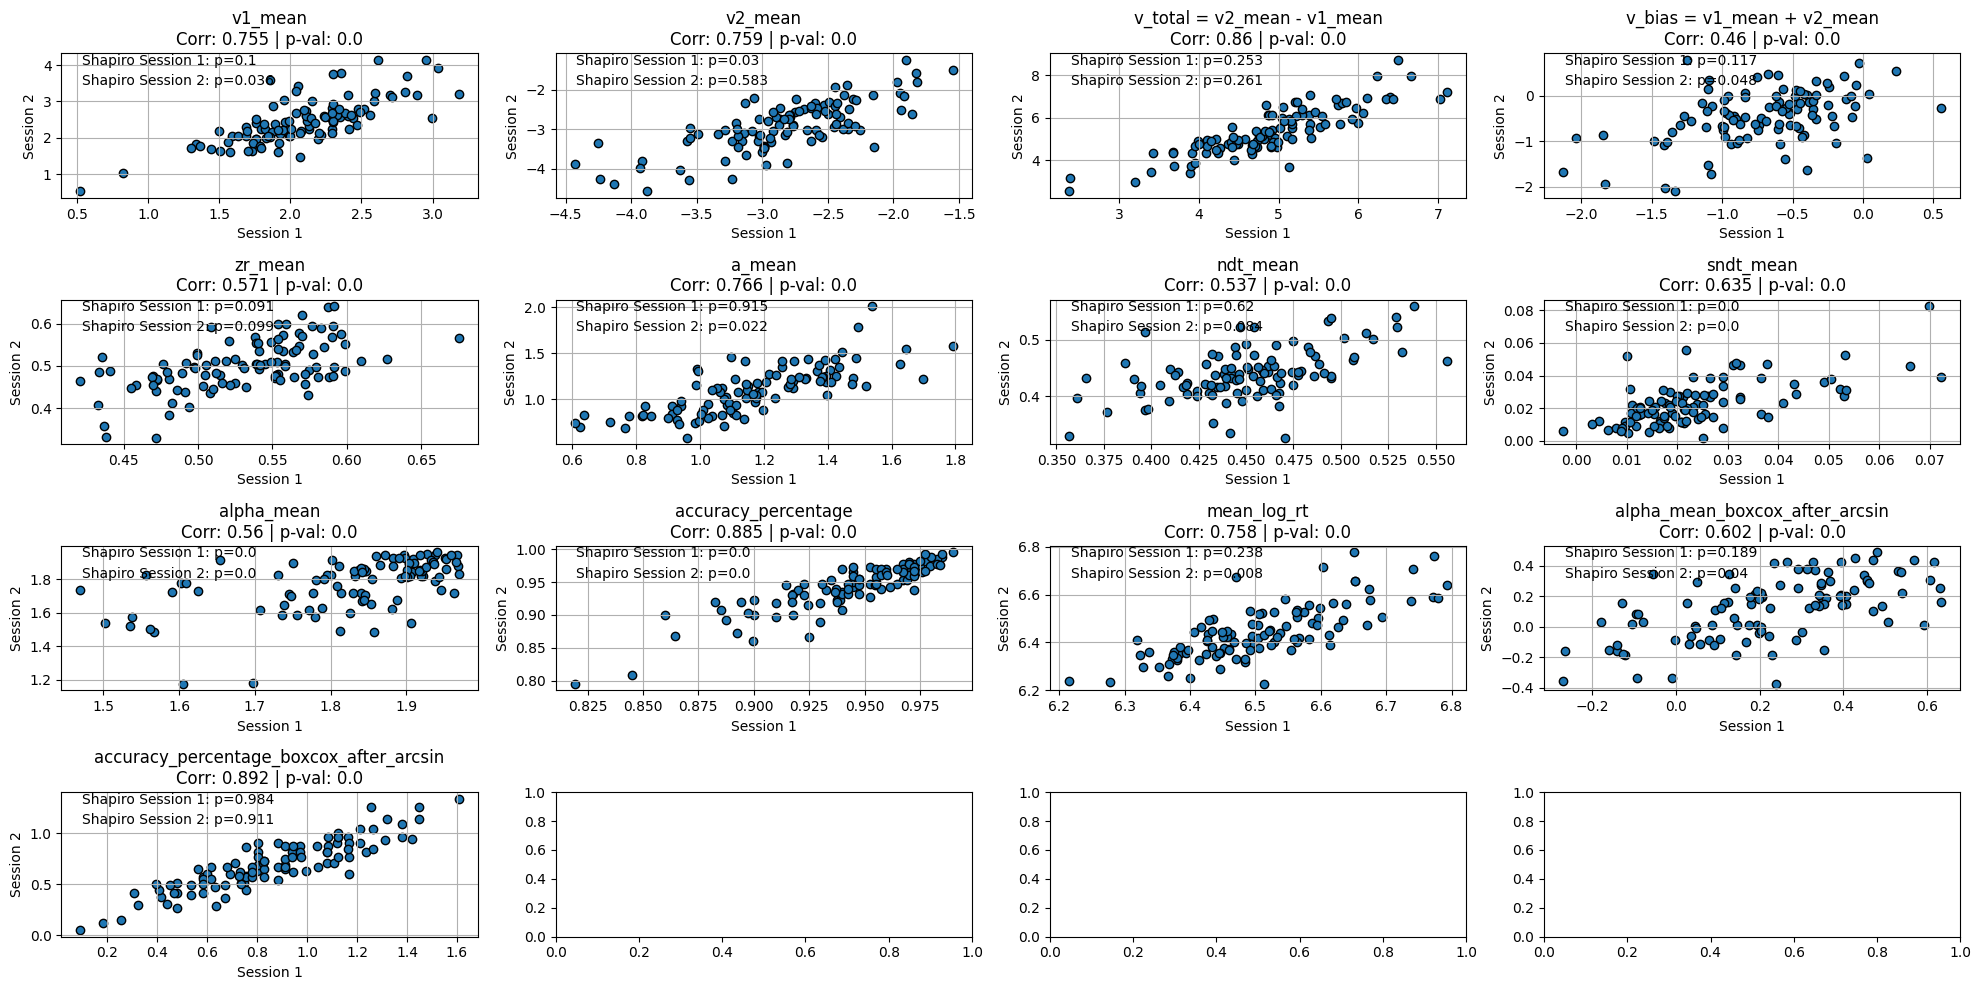

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2, pearsonr, shapiro



# Prepare the figure for subplots
num_vars = len(columns_for_analysis)
num_rows = int(np.ceil(np.sqrt(num_vars)))
num_cols = int(np.ceil(num_vars / num_rows))
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))  # Adjust the size as needed
axes = axes.flatten()

# Perform analysis for each variable and plot
for i, col in enumerate(columns_for_analysis):
    # Identify and remove outliers
    outlier_indices = identify_outliers([col], ldt_session_1_data, ldt_session_2_data)[col]
    outliers_dict = identify_outliers(columns_for_analysis, ldt_session_1_data, ldt_session_2_data)

    # Display the number of outliers for each column
    outlier_counts = {col: len(indices) for col, indices in outliers_dict.items()}
    print(outlier_counts)
    clean_data = pd.concat([
        ldt_session_1_data.set_index('ID')[col],
        ldt_session_2_data.set_index('ID')[col]
    ], axis=1).drop(outlier_indices)
    
    # Calculate Pearson correlation
    correlation, p_value_corr = pearsonr(clean_data.iloc[:, 0], clean_data.iloc[:, 1])
    
    # Test for normality
    _, p_value_shapiro_1 = shapiro(clean_data.iloc[:, 0])
    _, p_value_shapiro_2 = shapiro(clean_data.iloc[:, 1])
    
    # Round the results to three decimals
    correlation = round(correlation, 3)
    p_value_corr = round(p_value_corr, 3)
    p_value_shapiro_1 = round(p_value_shapiro_1, 3)
    p_value_shapiro_2 = round(p_value_shapiro_2, 3)
    
    # Plotting on the subplot
    ax = axes[i]
    ax.scatter(clean_data.iloc[:, 0], clean_data.iloc[:, 1], edgecolor='k')
    ax.set_title(f'{col}\nCorr: {correlation} | p-val: {p_value_corr}')
    ax.set_xlabel('Session 1')
    ax.set_ylabel('Session 2')
    ax.grid(True)
    
    # Annotate with Shapiro-Wilk test results
    ax.annotate(f'Shapiro Session 1: p={p_value_shapiro_1}', xy=(0.05, 0.92), xycoords='axes fraction')
    ax.annotate(f'Shapiro Session 2: p={p_value_shapiro_2}', xy=(0.05, 0.78), xycoords='axes fraction')

# Adjust layout for readability
plt.tight_layout()

# Save the figure
#plt.savefig('combined_correlation_plots.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axi

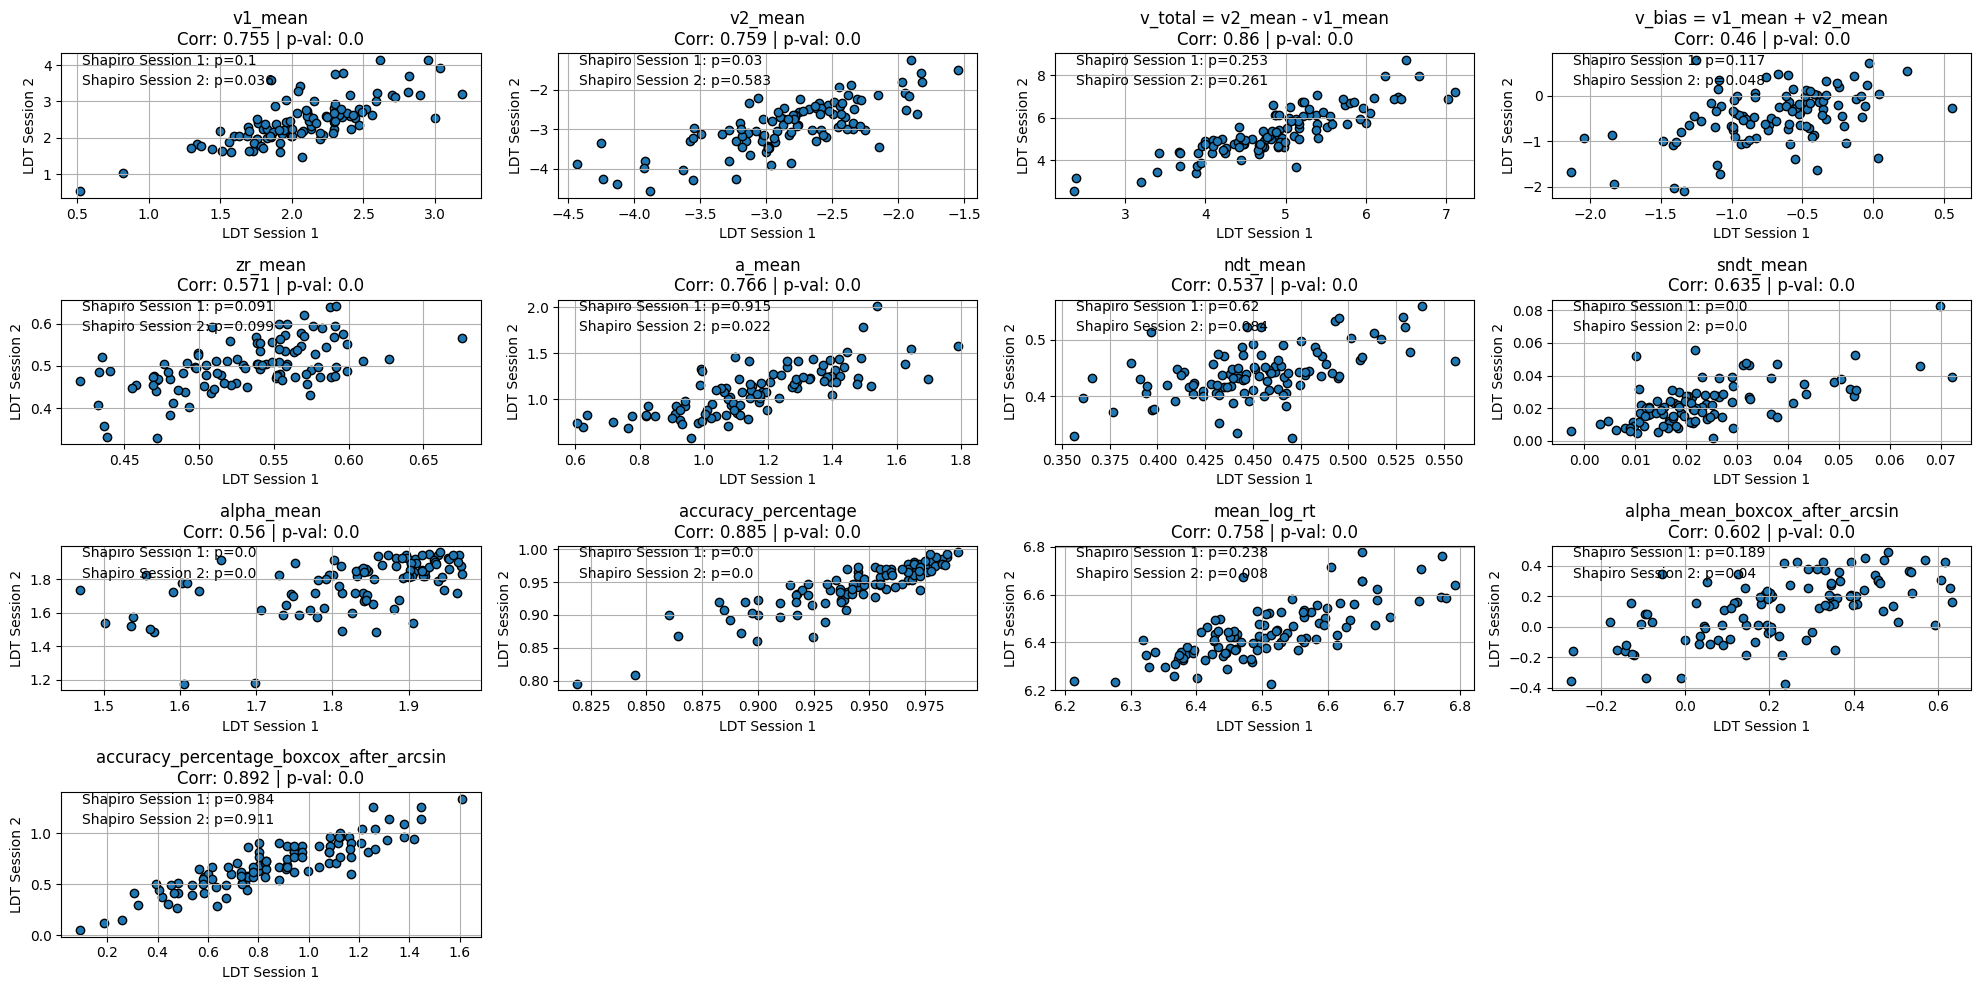

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2, pearsonr, shapiro



# Prepare the figure for subplots
num_vars = len(columns_for_analysis)
num_rows = int(np.ceil(np.sqrt(num_vars)))
num_cols = int(np.ceil(num_vars / num_rows))
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))  # Adjust the size as needed
axes = axes.flatten()


#############################################################
LDT_Bet_session_correlation_matrix = pd.DataFrame()

# Perform analysis for each variable and plot
for i, col in enumerate(columns_for_analysis):
    # Identify and remove outliers
    outlier_indices = identify_outliers([col], ldt_session_1_data, ldt_session_2_data)[col]
    clean_data = pd.concat([
        ldt_session_1_data.set_index('ID')[col],
        ldt_session_2_data.set_index('ID')[col]
    ], axis=1).drop(outlier_indices)
    
    # Calculate Pearson correlation
    correlation, p_value_corr = pearsonr(clean_data.iloc[:, 0], clean_data.iloc[:, 1])


    
    # Test for normality
    _, p_value_shapiro_1 = shapiro(clean_data.iloc[:, 0])
    _, p_value_shapiro_2 = shapiro(clean_data.iloc[:, 1])
    
    # Round the results to three decimals
    correlation = round(correlation, 3)
    LDT_Bet_session_correlation_matrix.loc[col,'LDT_Bet_session'] = correlation

    p_value_corr = round(p_value_corr, 3)
    p_value_shapiro_1 = round(p_value_shapiro_1, 3)
    p_value_shapiro_2 = round(p_value_shapiro_2, 3)
    
    # Plotting on the subplot
    ax = axes[i]
    ax.scatter(clean_data.iloc[:, 0], clean_data.iloc[:, 1], edgecolor='k')
    ax.set_title(f'{col}\nCorr: {correlation} | p-val: {p_value_corr}')
    ax.set_xlabel('LDT Session 1')
    ax.set_ylabel('LDT Session 2')
    ax.grid(True)
    
    # Annotate with Shapiro-Wilk test results
    ax.annotate(f'Shapiro Session 1: p={p_value_shapiro_1}', xy=(0.05, 0.92), xycoords='axes fraction')
    ax.annotate(f'Shapiro Session 2: p={p_value_shapiro_2}', xy=(0.05, 0.78), xycoords='axes fraction')

for ax in axes[len(columns_for_analysis):]:
    ax.set_visible(False)

# Adjust layout for readability
plt.tight_layout()

# Save the figure
plt.savefig('LDT_Between_session_combined_correlation_plots.png', dpi=300, bbox_inches='tight')

# Show the plot
#plt.show()


In [13]:
dict

dict

In [14]:
LDT_Bet_session_correlation_matrix

,LDT_Bet_session
v1_mean,0.755
v2_mean,0.759
v_total = v2_mean - v1_mean,0.860
v_bias = v1_mean + v2_mean,0.460
zr_mean,0.571
a_mean,0.766
ndt_mean,0.537
sndt_mean,0.635
alpha_mean,0.560
accuracy_percentage,0.885


/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axi

{'v1_mean': 0, 'v2_mean': 1, 'v_total = v2_mean - v1_mean': 0, 'v_bias = v1_mean + v2_mean': 0, 'zr_mean': 1, 'a_mean': 0, 'ndt_mean': 1, 'sndt_mean': 1, 'alpha_mean': 3, 'accuracy_percentage': 0, 'mean_log_rt': 0, 'alpha_mean_boxcox_after_arcsin': 1, 'accuracy_percentage_boxcox_after_arcsin': 0}
{'v1_mean': 0, 'v2_mean': 1, 'v_total = v2_mean - v1_mean': 0, 'v_bias = v1_mean + v2_mean': 0, 'zr_mean': 1, 'a_mean': 0, 'ndt_mean': 1, 'sndt_mean': 1, 'alpha_mean': 3, 'accuracy_percentage': 0, 'mean_log_rt': 0, 'alpha_mean_boxcox_after_arcsin': 1, 'accuracy_percentage_boxcox_after_arcsin': 0}
{'v1_mean': 0, 'v2_mean': 1, 'v_total = v2_mean - v1_mean': 0, 'v_bias = v1_mean + v2_mean': 0, 'zr_mean': 1, 'a_mean': 0, 'ndt_mean': 1, 'sndt_mean': 1, 'alpha_mean': 3, 'accuracy_percentage': 0, 'mean_log_rt': 0, 'alpha_mean_boxcox_after_arcsin': 1, 'accuracy_percentage_boxcox_after_arcsin': 0}
{'v1_mean': 0, 'v2_mean': 1, 'v_total = v2_mean - v1_mean': 0, 'v_bias = v1_mean + v2_mean': 0, 'zr_mean':

/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axi

{'v1_mean': 0, 'v2_mean': 1, 'v_total = v2_mean - v1_mean': 0, 'v_bias = v1_mean + v2_mean': 0, 'zr_mean': 1, 'a_mean': 0, 'ndt_mean': 1, 'sndt_mean': 1, 'alpha_mean': 3, 'accuracy_percentage': 0, 'mean_log_rt': 0, 'alpha_mean_boxcox_after_arcsin': 1, 'accuracy_percentage_boxcox_after_arcsin': 0}
{'v1_mean': 0, 'v2_mean': 1, 'v_total = v2_mean - v1_mean': 0, 'v_bias = v1_mean + v2_mean': 0, 'zr_mean': 1, 'a_mean': 0, 'ndt_mean': 1, 'sndt_mean': 1, 'alpha_mean': 3, 'accuracy_percentage': 0, 'mean_log_rt': 0, 'alpha_mean_boxcox_after_arcsin': 1, 'accuracy_percentage_boxcox_after_arcsin': 0}
{'v1_mean': 0, 'v2_mean': 1, 'v_total = v2_mean - v1_mean': 0, 'v_bias = v1_mean + v2_mean': 0, 'zr_mean': 1, 'a_mean': 0, 'ndt_mean': 1, 'sndt_mean': 1, 'alpha_mean': 3, 'accuracy_percentage': 0, 'mean_log_rt': 0, 'alpha_mean_boxcox_after_arcsin': 1, 'accuracy_percentage_boxcox_after_arcsin': 0}
{'v1_mean': 0, 'v2_mean': 1, 'v_total = v2_mean - v1_mean': 0, 'v_bias = v1_mean + v2_mean': 0, 'zr_mean':

/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axi

{'v1_mean': 0, 'v2_mean': 1, 'v_total = v2_mean - v1_mean': 0, 'v_bias = v1_mean + v2_mean': 0, 'zr_mean': 1, 'a_mean': 0, 'ndt_mean': 1, 'sndt_mean': 1, 'alpha_mean': 3, 'accuracy_percentage': 0, 'mean_log_rt': 0, 'alpha_mean_boxcox_after_arcsin': 1, 'accuracy_percentage_boxcox_after_arcsin': 0}


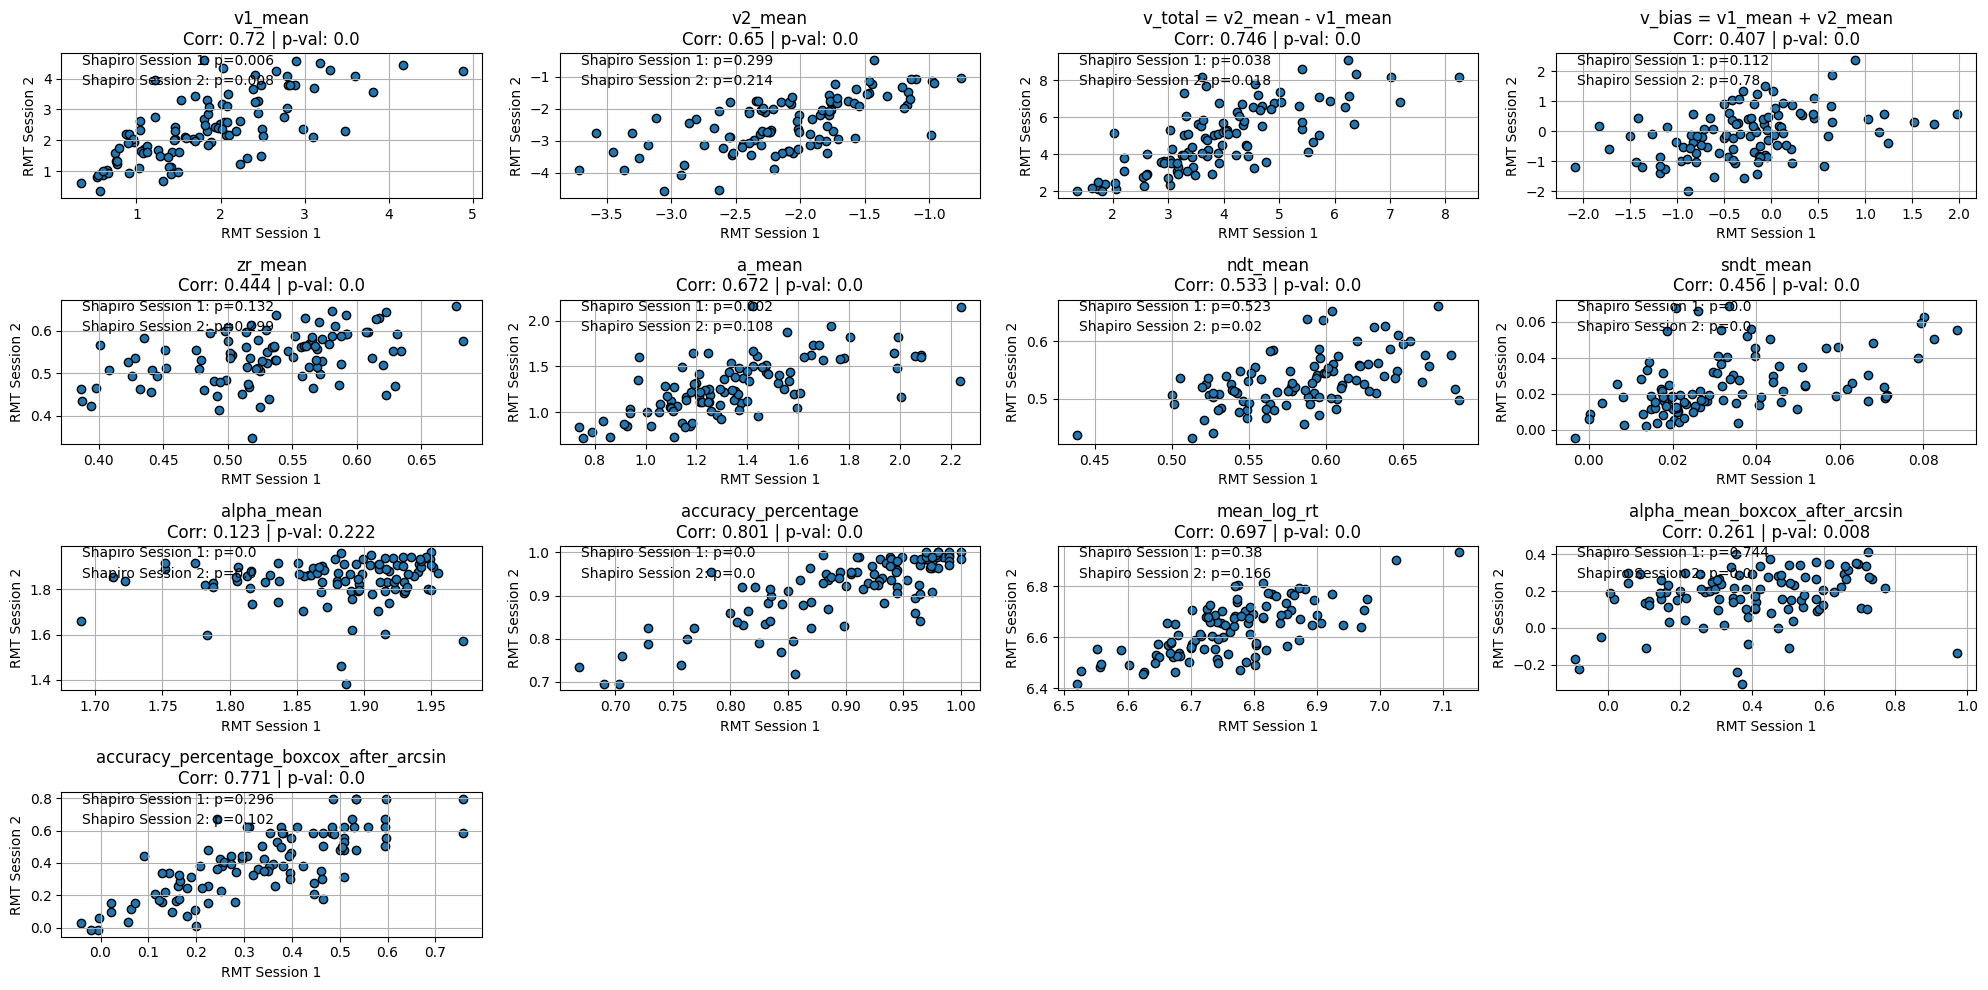

In [16]:
# Load the RMT Session 1 and Session 2 data
rmt_session_1_data = pd.read_csv('rmt_session_1_data_transformed.csv')
rmt_session_2_data = pd.read_csv('rmt_session_2_data_transformed.csv')

rmt_session_1_data.insert(3, "v_total = v2_mean - v1_mean", rmt_session_1_data['v1_mean']-rmt_session_1_data['v2_mean'], True)
rmt_session_1_data.insert(4, "v_bias = v1_mean + v2_mean", rmt_session_1_data['v1_mean']+rmt_session_1_data['v2_mean'], True)

rmt_session_2_data.insert(3, "v_total = v2_mean - v1_mean", rmt_session_2_data['v1_mean']-rmt_session_2_data['v2_mean'], True)
rmt_session_2_data.insert(4, "v_bias = v1_mean + v2_mean", rmt_session_2_data['v1_mean']+rmt_session_2_data['v2_mean'], True)



# Prepare the figure for subplots
num_vars = len(columns_for_analysis)
num_rows = int(np.ceil(np.sqrt(num_vars)))
num_cols = int(np.ceil(num_vars / num_rows))
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))  # Adjust the size as needed
axes = axes.flatten()



RMT_Bet_session_correlation_matrix = pd.DataFrame()

# Perform analysis for each variable and plot
for i, col in enumerate(columns_for_analysis):
    # Identify and remove outliers
    outlier_indices = identify_outliers([col], rmt_session_1_data, rmt_session_2_data)[col]
    
    clean_data = pd.concat([
        rmt_session_1_data.set_index('ID')[col],
        rmt_session_2_data.set_index('ID')[col]
    ], axis=1).drop(outlier_indices)
    
    # Calculate Pearson correlation
    correlation, p_value_corr = pearsonr(clean_data.iloc[:, 0], clean_data.iloc[:, 1])
    
    # Test for normality
    _, p_value_shapiro_1 = shapiro(clean_data.iloc[:, 0])
    _, p_value_shapiro_2 = shapiro(clean_data.iloc[:, 1])
    
    # Round the results to three decimals
    correlation = round(correlation, 3)
    RMT_Bet_session_correlation_matrix.loc[col,'RMT_Bet_session']=correlation
    p_value_corr = round(p_value_corr, 3)
    p_value_shapiro_1 = round(p_value_shapiro_1, 3)
    p_value_shapiro_2 = round(p_value_shapiro_2, 3)
    
    # Plotting on the subplot
    ax = axes[i]
    ax.scatter(clean_data.iloc[:, 0], clean_data.iloc[:, 1], edgecolor='k')
    ax.set_title(f'{col}\nCorr: {correlation} | p-val: {p_value_corr}')
    ax.set_xlabel('RMT Session 1')
    ax.set_ylabel('RMT Session 2')
    ax.grid(True)
    
    # Annotate with Shapiro-Wilk test results
    ax.annotate(f'Shapiro Session 1: p={p_value_shapiro_1}', xy=(0.05, 0.92), xycoords='axes fraction')
    ax.annotate(f'Shapiro Session 2: p={p_value_shapiro_2}', xy=(0.05, 0.78), xycoords='axes fraction')

# Hide any unused subplots
for ax in axes[len(columns_for_analysis):]:
    ax.set_visible(False)

# Adjust layout for readability and save the figure
plt.tight_layout()
plt.savefig('RMT_Between_session_combined_correlation_plots.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [16]:
RMT_Bet_session_correlation_matrix

,RMT_Bet_session
v1_mean,0.720
v2_mean,0.650
v_total = v2_mean - v1_mean,0.746
v_bias = v1_mean + v2_mean,0.407
zr_mean,0.444
a_mean,0.672
ndt_mean,0.533
sndt_mean,0.456
alpha_mean,0.123
accuracy_percentage,0.801


# Makign Data Suitable for Across task correlation for session to LDT_Session_2 & RMT_Session_2

In [17]:
ldt_session_2_data = new_ldt_session_2_data
rmt_session_2_data = rmt_session_2_data
ldt_session_2_data

,Unnamed: 0,Experiment,v1_mean,v_total = v2_mean - v1_mean,v_bias = v1_mean + v2_mean,v2_mean,zr_mean,a_mean,ndt_mean,sndt_mean,...,RT_Cor_arr,ID,Task,Session,alpha_shifted,alpha_clipped,alpha_arcsin,alpha_mean_boxcox_after_arcsin,accuracy_arcsin,accuracy_percentage_boxcox_after_arcsin
0,238,001_class_words_part_2.dat,1.599007,3.417291,-0.219277,-1.818284,0.454611,0.832779,0.443185,0.038965,...,0 2.457\n1 0.746\n2 0.850\n4 ...,1,LDT,Session 2,0.676160,0.676160,0.965423,-0.033594,1.187299,0.273387
1,179,002_class_words_part_2.dat,1.681567,4.882388,-1.519253,-3.200821,0.567263,1.190086,0.558729,0.046386,...,0 0.625\n1 0.594\n2 0.794\n3 ...,2,LDT,Session 2,0.878556,0.878556,1.214839,0.254828,1.333769,0.650661
2,308,003_class_words_part_2.dat,2.574965,5.713119,-0.563188,-3.138154,0.504600,1.412809,0.447879,0.005543,...,0 0.961\n1 0.666\n2 0.578\n4 ...,3,LDT,Session 2,0.924393,0.924393,1.292240,0.367383,1.438120,1.043981
3,111,004_class_words_part_2.dat,1.463842,3.669596,-0.741911,-2.205754,0.578036,0.929065,0.410085,0.036107,...,0 0.649\n1 0.570\n2 0.602\n4 ...,4,LDT,Session 2,0.644288,0.644288,0.931768,-0.064435,1.232291,0.370875
4,346,005_class_words_part_2.dat,3.909046,7.946730,-0.128637,-4.037684,0.476833,1.226525,0.416821,0.011327,...,0 1.144\n1 0.562\n2 0.609\n3 ...,5,LDT,Session 2,0.818432,0.818432,1.130611,0.145137,1.458759,1.136751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,210,4009_class_words_part_2.dat,1.725382,3.874914,-0.424149,-2.149532,0.527691,1.871589,0.431408,0.009328,...,1 1.589\n2 0.874\n4 0.753\n5 ...,4009,LDT,Session 2,0.942730,0.942730,1.329139,0.425145,1.415041,0.946446
100,202,4010_class_words_part_2.dat,2.122715,4.866556,-0.621126,-2.743841,0.593043,0.835049,0.417145,0.014657,...,0 1.367\n1 0.592\n2 0.559\n4 ...,4010,LDT,Session 2,0.736224,0.736224,1.031431,0.032255,1.279465,0.489832
101,277,4011_class_words_part_2.dat,1.615878,3.437596,-0.205840,-1.821718,0.454229,0.814446,0.420229,0.025474,...,1 0.801\n2 0.794\n3 0.505\n4 ...,4011,LDT,Session 2,0.501566,0.501566,0.786964,-0.177237,1.197742,0.294718
102,22,4012_class_words_part_2.dat,2.041466,4.776915,-0.693983,-2.735449,0.509337,1.164384,0.377721,0.027880,...,0 0.848\n1 0.632\n2 0.688\n3 ...,4012,LDT,Session 2,0.576605,0.576605,0.862306,-0.122472,1.323329,0.617612


In [18]:
ldt_session_2_data=ldt_session_2_data.sort_values(by=['ID'], ascending=False)
rmt_session_2_data=rmt_session_2_data.sort_values(by=['ID'], ascending=False)
ldt_session_2_data=ldt_session_2_data[ldt_session_2_data['ID'].isin(rmt_session_2_data['ID'])]

# Across task correlation for session to LDT_Session_2 & RMT_Session_2

/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axi

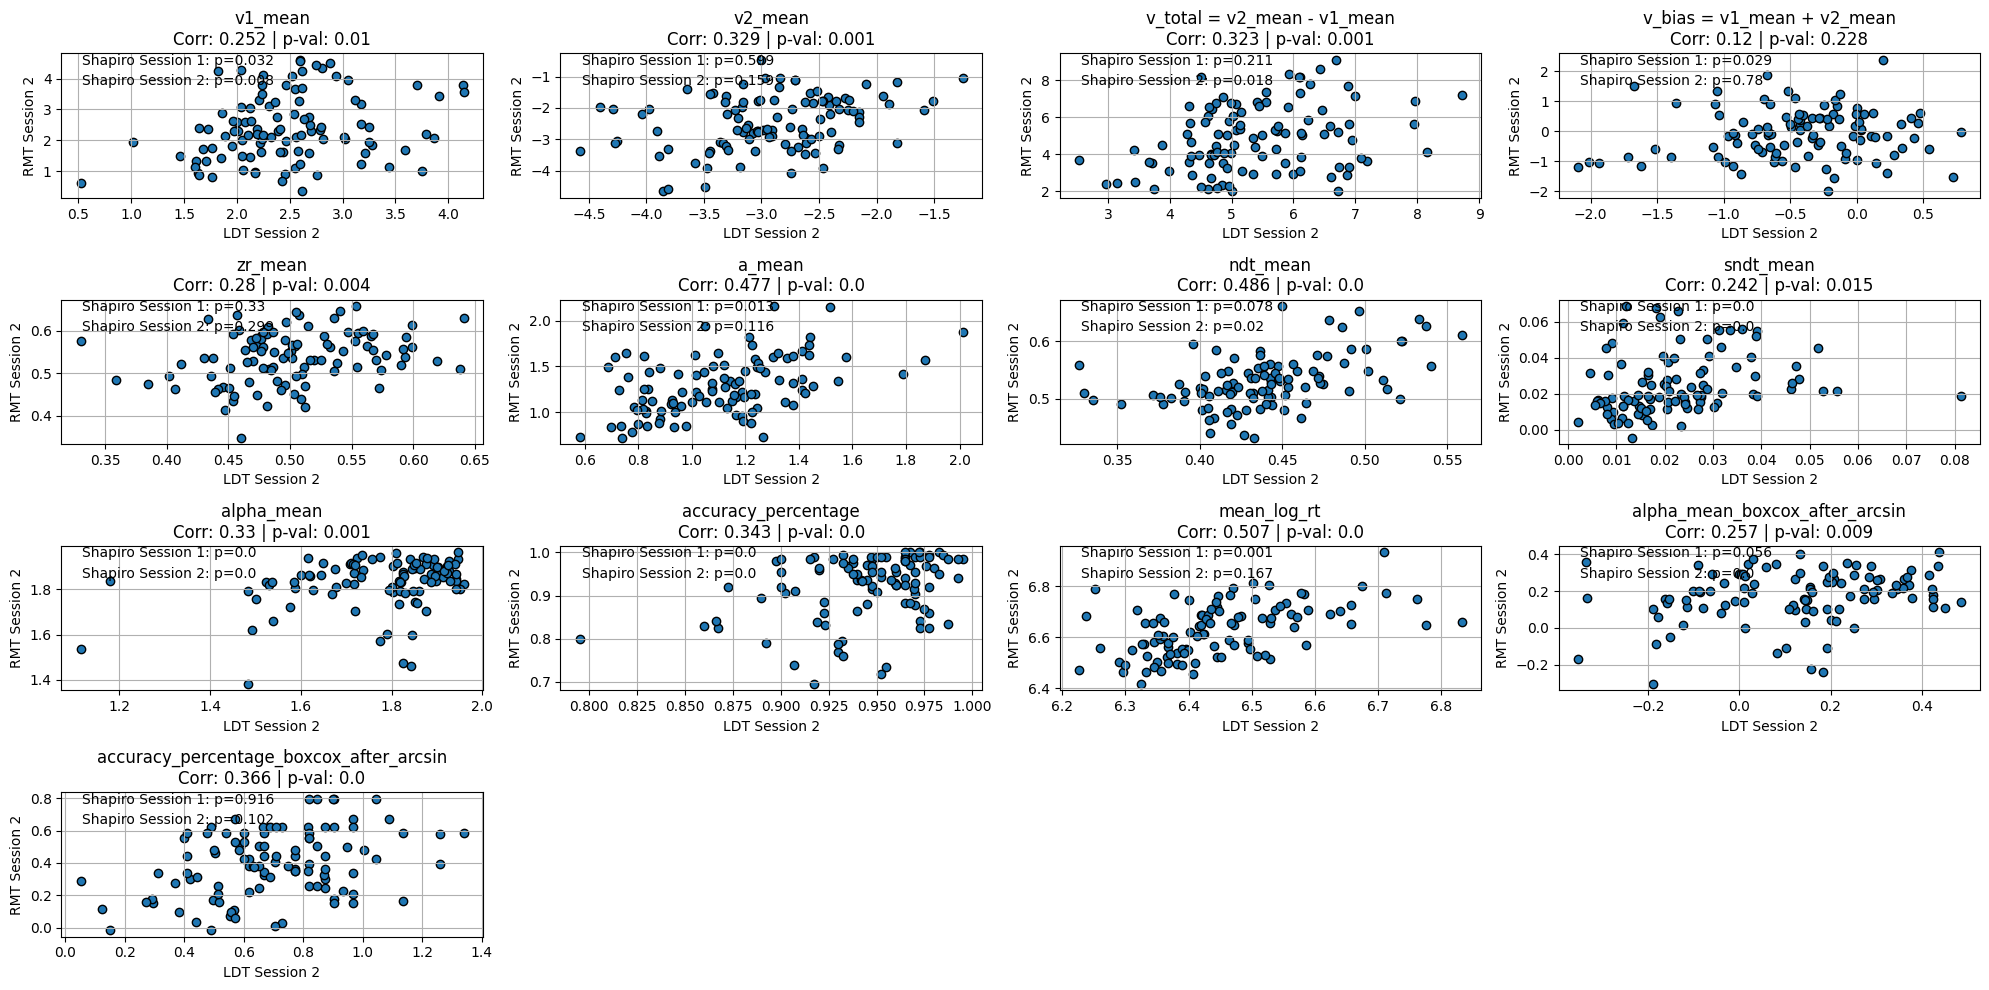

In [19]:

# Prepare the figure for subplots
num_vars = len(columns_for_analysis)
num_rows = int(np.ceil(np.sqrt(num_vars)))
num_cols = int(np.ceil(num_vars / num_rows))
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))  # Adjust the size as needed
axes = axes.flatten()


Across_task_session_2_correlation_matrix = pd.DataFrame()

# Perform analysis for each variable and plot
for i, col in enumerate(columns_for_analysis):
    # Identify and remove outliers
    outlier_indices = identify_outliers([col], ldt_session_2_data, rmt_session_2_data)[col]
    
    clean_data = pd.concat([
        ldt_session_2_data.set_index('ID')[col],
        rmt_session_2_data.set_index('ID')[col]
    ], axis=1).drop(outlier_indices)
    
    # Calculate Pearson correlation
    correlation, p_value_corr = pearsonr(clean_data.iloc[:, 0], clean_data.iloc[:, 1])
    
    # Test for normality
    _, p_value_shapiro_1 = shapiro(clean_data.iloc[:, 0])
    _, p_value_shapiro_2 = shapiro(clean_data.iloc[:, 1])
    
    # Round the results to three decimals
    correlation = round(correlation, 3)
    # Across_task_session_2_correlation_matrix.loc[col,'across_s1'] = correlation
    Across_task_session_2_correlation_matrix.loc[col,'across_s2'] = correlation

    p_value_corr = round(p_value_corr, 3)
    p_value_shapiro_1 = round(p_value_shapiro_1, 3)
    p_value_shapiro_2 = round(p_value_shapiro_2, 3)
    
    # Plotting on the subplot
    ax = axes[i]
    ax.scatter(clean_data.iloc[:, 0], clean_data.iloc[:, 1], edgecolor='k')
    ax.set_title(f'{col}\nCorr: {correlation} | p-val: {p_value_corr}')
    ax.set_xlabel('LDT Session 2')
    ax.set_ylabel('RMT Session 2')
    ax.grid(True)
    
    # Annotate with Shapiro-Wilk test results
    ax.annotate(f'Shapiro Session 1: p={p_value_shapiro_1}', xy=(0.05, 0.92), xycoords='axes fraction')
    ax.annotate(f'Shapiro Session 2: p={p_value_shapiro_2}', xy=(0.05, 0.78), xycoords='axes fraction')

# Hide any unused subplots
for ax in axes[len(columns_for_analysis):]:
    ax.set_visible(False)

# Adjust layout for readability and save the figure
plt.tight_layout()
plt.savefig('Across_Task_Session_2_combined_correlation_plots.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [19]:
outliers_dict = identify_outliers(columns_for_analysis, ldt_session_1_data, rmt_session_1_data)

# Display the number of outliers for each column
outlier_counts = {col: len(indices) for col, indices in outliers_dict.items()}
print(outlier_counts)

{'v1_mean': 1, 'v2_mean': 0, 'v_total = v2_mean - v1_mean': 1, 'v_bias = v1_mean + v2_mean': 0, 'zr_mean': 0, 'a_mean': 1, 'ndt_mean': 0, 'sndt_mean': 2, 'alpha_mean': 3, 'accuracy_percentage': 1, 'mean_log_rt': 1, 'alpha_mean_boxcox_after_arcsin': 0, 'accuracy_percentage_boxcox_after_arcsin': 0}


/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axi

In [20]:
Across_task_session_2_correlation_matrix

,across_s2
v1_mean,0.252
v2_mean,0.329
v_total = v2_mean - v1_mean,0.323
v_bias = v1_mean + v2_mean,0.120
zr_mean,0.280
a_mean,0.477
ndt_mean,0.486
sndt_mean,0.242
alpha_mean,0.330
accuracy_percentage,0.343


# Across Task Session 1 Making data suitable 

In [21]:
ldt_session_1_data = new_ldt_session_1_data
rmt_session_1_data = rmt_session_1_data
ldt_session_1_data

,Unnamed: 0,Experiment,v1_mean,v_total = v2_mean - v1_mean,v_bias = v1_mean + v2_mean,v2_mean,zr_mean,a_mean,ndt_mean,sndt_mean,...,RT_Cor_arr,ID,Task,Session,alpha_shifted,alpha_clipped,alpha_arcsin,alpha_mean_boxcox_after_arcsin,accuracy_arcsin,accuracy_percentage_boxcox_after_arcsin
0,368,001_class_words_part_1.dat,1.914128,3.887838,-0.059582,-1.973710,0.458063,1.068551,0.461645,0.072309,...,1 0.777\n3 1.250\n5 1.026\n6 ...,1,LDT,Session 1,0.887123,0.887123,1.228159,0.301774,1.248628,0.478991
1,108,002_class_words_part_1.dat,1.444512,3.991271,-1.102247,-2.546759,0.538214,1.205062,0.538549,0.032389,...,0 0.778\n1 0.602\n2 1.556\n3 ...,2,LDT,Session 1,0.968847,0.968847,1.393365,0.629899,1.274187,0.564924
2,347,003_class_words_part_1.dat,2.274300,5.766528,-1.217928,-3.492228,0.558717,1.293333,0.451020,0.014519,...,0 1.090\n1 0.786\n2 1.628\n3 ...,3,LDT,Session 1,0.951431,0.951431,1.348588,0.530515,1.420228,1.264399
3,97,004_class_words_part_1.dat,2.067894,5.128521,-0.992734,-3.060628,0.567937,0.912611,0.458700,0.049127,...,0 0.578\n1 0.595\n2 0.579\n3 ...,4,LDT,Session 1,0.738777,0.738777,1.034333,0.035848,1.303033,0.673343
4,62,005_class_words_part_1.dat,3.035132,6.665071,-0.594806,-3.629939,0.470022,1.330673,0.434927,0.020764,...,0 0.906\n1 0.546\n2 0.745\n3 ...,5,LDT,Session 1,0.921688,0.921688,1.287166,0.407112,1.448014,1.446927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,393,4009_class_words_part_1.dat,1.795025,3.949919,-0.359869,-2.154894,0.577394,2.215688,0.365601,0.018031,...,1 2.352\n2 1.453\n4 1.600\n5 ...,4009,LDT,Session 1,0.917695,0.917695,1.279819,0.393311,1.443965,1.419175
100,242,4010_class_words_part_1.dat,2.199252,4.991704,-0.593199,-2.792451,0.576494,1.002926,0.394462,0.037934,...,0 0.725\n1 0.622\n2 0.647\n4 ...,4010,LDT,Session 1,0.469588,0.469588,0.754967,-0.178333,1.303033,0.673343
101,176,4011_class_words_part_1.dat,1.577086,3.400180,-0.246008,-1.823094,0.469439,0.777719,0.418415,0.032518,...,1 0.741\n2 0.552\n3 0.461\n4 ...,4011,LDT,Session 1,0.561313,0.561313,0.846866,-0.125773,1.193568,0.322504
102,341,4012_class_words_part_1.dat,1.845768,4.678905,-0.987368,-2.833136,0.548847,1.144133,0.398236,0.023608,...,0 1.509\n1 0.566\n3 0.872\n4 ...,4012,LDT,Session 1,0.779491,0.779491,1.081976,0.090823,1.328336,0.779336


In [22]:
ldt_session_1_data=ldt_session_1_data.sort_values(by=['ID'], ascending=False)
rmt_session_1_data=rmt_session_1_data.sort_values(by=['ID'], ascending=False)
ldt_session_1_data=ldt_session_1_data[ldt_session_1_data['ID'].isin(rmt_session_1_data['ID'])]

/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axi

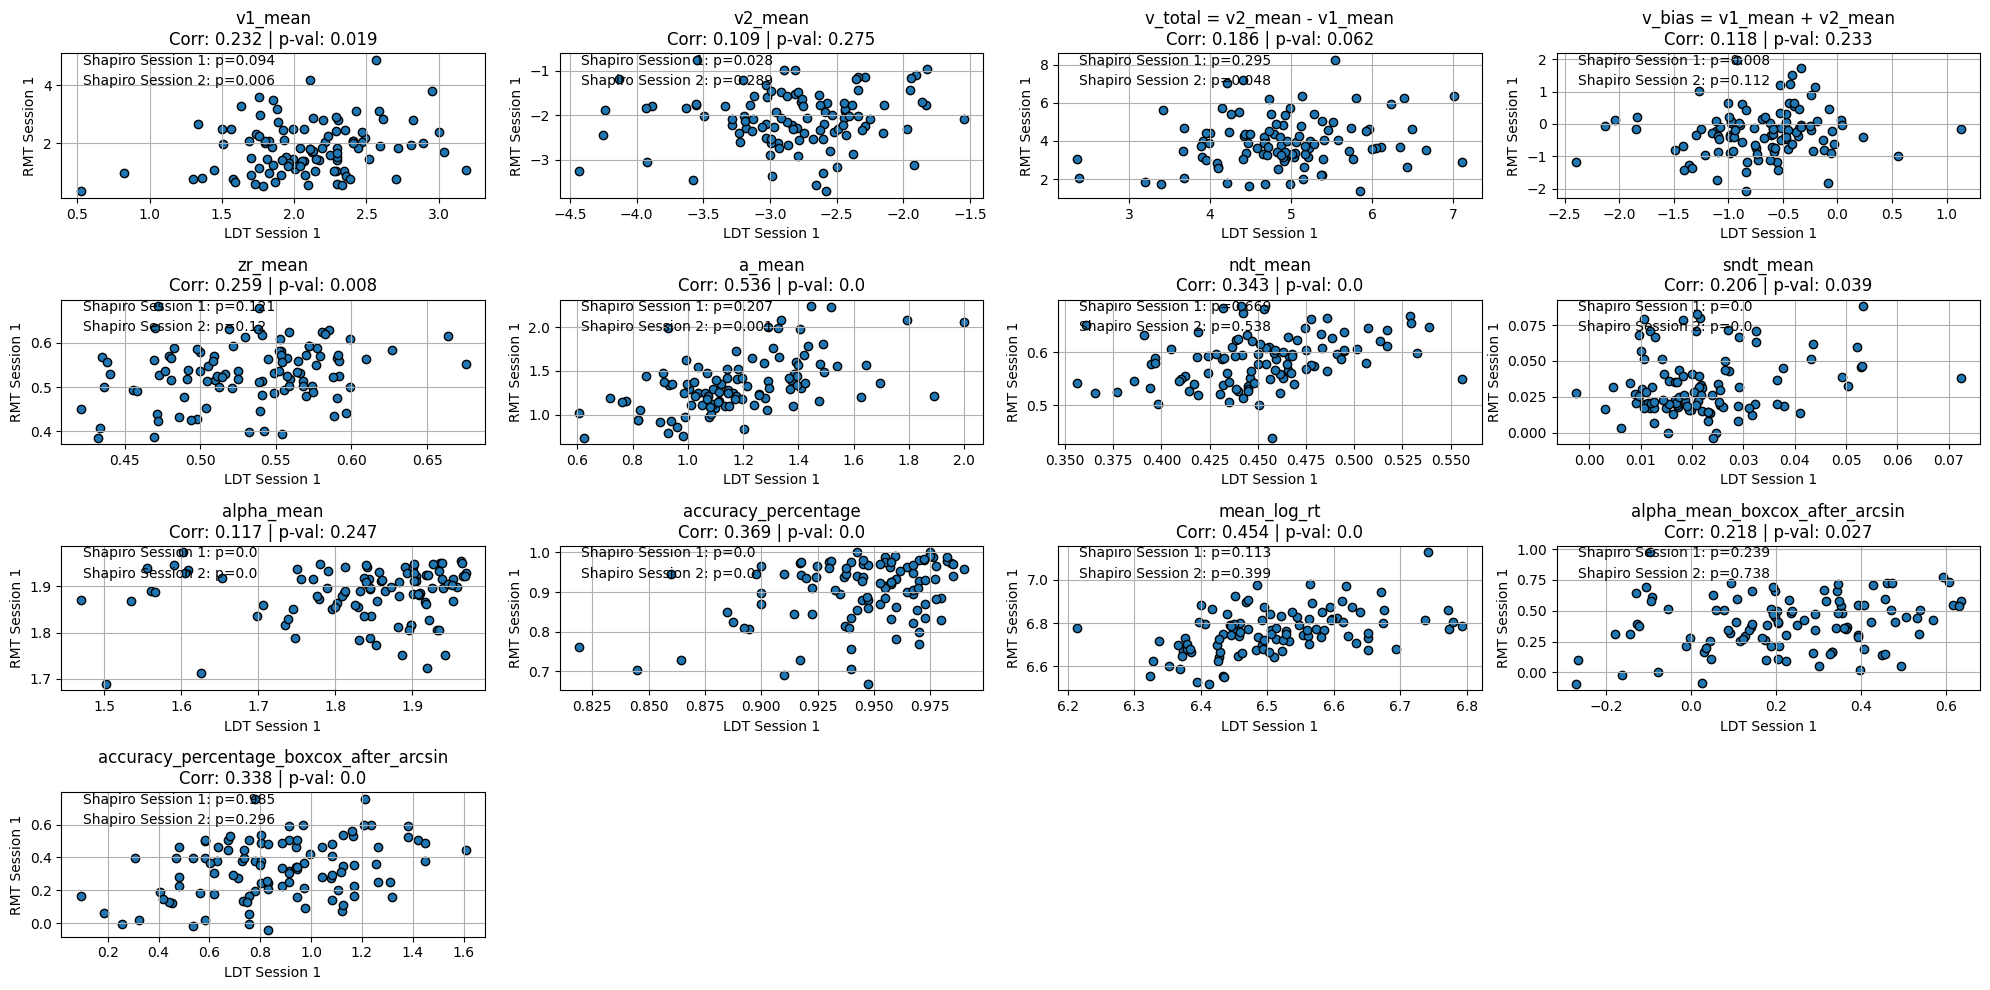

In [23]:

# Prepare the figure for subplots
num_vars = len(columns_for_analysis)
num_rows = int(np.ceil(np.sqrt(num_vars)))
num_cols = int(np.ceil(num_vars / num_rows))
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))  # Adjust the size as needed
axes = axes.flatten()


Across_task_session_1_correlation_matrix = pd.DataFrame()
# Perform analysis for each variable and plot
for i, col in enumerate(columns_for_analysis):
    # Identify and remove outliers
    outlier_indices = identify_outliers([col], ldt_session_1_data, rmt_session_1_data)[col]
    clean_data = pd.concat([
        ldt_session_1_data.set_index('ID')[col],
        rmt_session_1_data.set_index('ID')[col]
    ], axis=1).drop(outlier_indices)
    
    # Calculate Pearson correlation
    correlation, p_value_corr = pearsonr(clean_data.iloc[:, 0], clean_data.iloc[:, 1])
    
    # Test for normality
    _, p_value_shapiro_1 = shapiro(clean_data.iloc[:, 0])
    _, p_value_shapiro_2 = shapiro(clean_data.iloc[:, 1])
    
    # Round the results to three decimals
    correlation = round(correlation, 3)
    p_value_corr = round(p_value_corr, 3)
    Across_task_session_1_correlation_matrix.loc[col,'across_s1']=correlation
    p_value_shapiro_1 = round(p_value_shapiro_1, 3)
    p_value_shapiro_2 = round(p_value_shapiro_2, 3)
    
    # Plotting on the subplot
    ax = axes[i]
    ax.scatter(clean_data.iloc[:, 0], clean_data.iloc[:, 1], edgecolor='k')
    ax.set_title(f'{col}\nCorr: {correlation} | p-val: {p_value_corr}')
    ax.set_xlabel('LDT Session 1')
    ax.set_ylabel('RMT Session 1')
    ax.grid(True)
    
    # Annotate with Shapiro-Wilk test results
    ax.annotate(f'Shapiro Session 1: p={p_value_shapiro_1}', xy=(0.05, 0.92), xycoords='axes fraction')
    ax.annotate(f'Shapiro Session 2: p={p_value_shapiro_2}', xy=(0.05, 0.78), xycoords='axes fraction')

# Hide any unused subplots
for ax in axes[len(columns_for_analysis):]:
    ax.set_visible(False)

# Adjust layout for readability and save the figure
plt.tight_layout()
plt.savefig('Across_Task_Session_1_combined_correlation_plots.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [24]:
Across_task_session_1_correlation_matrix

,across_s1
v1_mean,0.232
v2_mean,0.109
v_total = v2_mean - v1_mean,0.186
v_bias = v1_mean + v2_mean,0.118
zr_mean,0.259
a_mean,0.536
ndt_mean,0.343
sndt_mean,0.206
alpha_mean,0.117
accuracy_percentage,0.369


In [25]:
reliability = [LDT_Bet_session_correlation_matrix,
               RMT_Bet_session_correlation_matrix,
    Across_task_session_1_correlation_matrix,
Across_task_session_2_correlation_matrix,

]

In [26]:
Across_task_session_1_correlation_matrix

,across_s1
v1_mean,0.232
v2_mean,0.109
v_total = v2_mean - v1_mean,0.186
v_bias = v1_mean + v2_mean,0.118
zr_mean,0.259
a_mean,0.536
ndt_mean,0.343
sndt_mean,0.206
alpha_mean,0.117
accuracy_percentage,0.369


In [27]:
reliabliity_datafram = pd.concat(reliability, axis=1, join='inner')


In [28]:
reliabliity_datafram.to_csv('study_1_bet&acros_reliabliity_datafram.csv',index=True)

In [29]:
pd.read_csv('study_1_bet&acros_reliabliity_datafram.csv')

,Unnamed: 0,LDT_Bet_session,RMT_Bet_session,across_s1,across_s2
0,v1_mean,0.755,0.720,0.232,0.252
1,v2_mean,0.759,0.650,0.109,0.329
2,v_total = v2_mean - v1_mean,0.860,0.746,0.186,0.323
3,v_bias = v1_mean + v2_mean,0.460,0.407,0.118,0.120
4,zr_mean,0.571,0.444,0.259,0.280
5,a_mean,0.766,0.672,0.536,0.477
6,ndt_mean,0.537,0.533,0.343,0.486
7,sndt_mean,0.635,0.456,0.206,0.242
8,alpha_mean,0.560,0.123,0.117,0.330
9,accuracy_percentage,0.885,0.801,0.369,0.343
